# Exploration of openaq data

This notebook explains the exploration of openaq sqs data. The goal is to:
- Read in openaq sqs data
- Have an understanding of the different attributes
- Perform a comparison with public openaq data
- Perform a more in depth study on
    - Location attributes
    - data frequency and completeness


In [8]:
# imports and environment setup
import json
import sys
import logging

import boto3

import polars as pl
%matplotlib widget
import matplotlib.pyplot as plt


from geopy.geocoders import Nominatim
from geopy import distance

sys.path.append("../config")
from _secrets import profile_name, region_name, queue_url


logging.basicConfig(level=logging.INFO)
#logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

boto3.setup_default_session(profile_name=profile_name)


## Read in openaq sqs messages

Messages are read in from the queue and saved locally. The functionallity to get the messages is implemented in the openaqtools.sqs library and is based on ther boto3 package. The extra functionallity allows to get all the messages on the queue as well as transforming them to a polars dataframe. The process of saving the data locally is not included, hence is executed manually in the code below.

Possible improvements:
- Logging mechanism in Jupyter notebook was not functioning correctly so loggings al set as warnings
- Currently only the content of the message is processed. Metadata could also be explored
- Automation of local storage. Currently local storage could accidentaly be overwritten.


In [2]:
from openaqtools.sqs import receive_messages, messages_to_df

message_filename = "../data/messages.parquet"

# option1: read in locally
df_messages = pl.read_parquet(message_filename)

# option2: retreive from AWS (watch out with saving to parquet!)
# messages = receive_messages(queue_url, region_name, max_nr_messages=50)
# df_messages = messages_to_df(messages)
#df_messages.write_parquet(message_filename)

# Basic processing of raw data
df_messages = df_messages.unnest("date", "coordinates")
df_messages = df_messages.with_columns(pl.col(["utc", "local"]).str.to_datetime())

# show some data
df_messages.head()


locationId,location,parameter,value,utc,local,unit,latitude,longitude,country,city,isMobile,isAnalysis,entity,sensorType
i64,str,str,f64,datetime[μs],"datetime[μs, UTC]",str,f64,f64,str,str,bool,bool,str,str
3450,"""Massenhoven""","""pm10""",22.824282,2023-10-28 16:16:54.554860,2023-10-28 14:16:54.554860 UTC,"""µg/m³""",51.198627,4.6364247,"""BE""","""Massenhoven""",true,true,"""radio""","""low-cost"""
3450,"""Massenhoven""","""pm25""",1.63125,2023-10-28 17:11:41.554582,2023-10-28 15:11:41.554582 UTC,"""µg/m³""",51.198627,4.6364247,"""BE""","""Massenhoven""",true,true,"""radio""","""low-cost"""
3119,"""Goetsenhoven""","""pm25""",8.7466,2023-10-28 16:19:09.553996,2023-10-28 14:19:09.553996 UTC,"""µg/m³""",50.76781,4.95114,"""BE""","""Goetsenhoven""",false,true,"""hot""","""reference grad…"
8857,"""Watervliet""","""no2""",99.9,2023-10-28 16:33:48.553533,2023-10-28 14:33:48.553533 UTC,"""µg/m³""",51.276517,3.6270198,"""BE""","""Watervliet""",false,false,"""particularly""","""low-cost"""
8857,"""Watervliet""","""pm25""",11.508267,2023-10-28 16:28:30.553649,2023-10-28 14:28:30.553649 UTC,"""µg/m³""",51.276517,3.6270198,"""BE""","""Watervliet""",false,false,"""particularly""","""low-cost"""


## Read in public openaq data

Below we do a spotcheck to see chat is in the public dataset. The goal is to see if the same data is available. Data is fetched via a python library: https://py-openaq.readthedocs.io/en/latest/

Some conclusions:
- Data in public openaq resource is not equal to data in sqs que:
    - Averaging periods and source name are not available in sqs data
    - isMobile, isAnalysis, entity and sensorType are not available in public dataset

In [16]:
import openaq

api = openaq.OpenAQ()
openaq_data = api.latest(city="Antwerpen", limit=1)
print(json.dumps(openaq_data, indent=2))

[
  200,
  {
    "meta": {
      "name": "openaq-api",
      "license": "",
      "website": "/",
      "page": 1,
      "limit": 1,
      "found": 19,
      "pages": 19
    },
    "results": [
      {
        "location": "BETM802",
        "city": "Antwerpen",
        "country": "BE",
        "coordinates": {
          "latitude": 51.2609897078635,
          "longitude": 4.42439900693533
        },
        "measurements": [
          {
            "parameter": "no2",
            "value": 10.5,
            "lastUpdated": "2023-11-01T10:00:00+00:00",
            "unit": "\u00b5g/m\u00b3",
            "sourceName": "EEA Belgium",
            "averagingPeriod": {
              "value": 3600,
              "unit": "seconds"
            }
          },
          {
            "parameter": "so2",
            "value": 3.5,
            "lastUpdated": "2017-03-14T11:00:00+00:00",
            "unit": "\u00b5g/m\u00b3",
            "sourceName": "EEA Belgium",
            "averagingPeriod": {
    

## First exploration of sqs dataset

Goal is to do high level analysis of the dataset. Some questions and answers below.

### Are all records are unique? Yes

In [21]:
# Check that all records are unique
print(f"amount of unique records: {len(df.unique())}")
print(f"amount of records: {len(df)}")

amount of unique records: 40000
amount of records: 40000


### Are all readings are in Belgium? Yes

In [24]:
# Check if all readings are in belgium
print(df["country"].unique())

shape: (1,)
Series: 'country' [str]
[
	"BE"
]


### Is location equal to city? Yes

In [25]:
# check if location is equal to city
print(df.select(pl.col("city").alias("temp")).frame_equal(df.select(pl.col("location").alias("temp"))))

True


### Does locationID have a one to one relation with location? No: Further analysis to be performed (see below)

In [27]:
# check if locationId links to location
print(df.group_by(["location", "locationId"]).agg(pl.count()).group_by("location").agg(pl.count()).sort("count", descending=True))
# spot check
# print(df.group_by(["location", "locationId"]).agg(pl.count()).filter(pl.col("location") == "Paifve"))

shape: (814, 2)
┌─────────────────┬───────┐
│ location        ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ Cornimont       ┆ 4     │
│ Paifve          ┆ 4     │
│ Vyle-Et-Tharoul ┆ 4     │
│ Arc-Wattripont  ┆ 3     │
│ …               ┆ …     │
│ Dourbes         ┆ 1     │
│ Itterbeek       ┆ 1     │
│ Vezin           ┆ 1     │
│ Furfooz         ┆ 1     │
└─────────────────┴───────┘


### What is the meaning of parameter?
Parameter corresponds to a pollutant type. This can be found on the openaq website (https://explore.openaq.org/). SQS data contains a subset of all the available pollutants: pm10, o3, pm25, no2, so2, co. A distinction can be made between
    - partical indicators (pm10, pm25): these can be reduced by a mechanical filter
    - chemical indicators (o3, so2, no2, co): these pollutants most likely require chemical filtration systems

In [28]:
# Check parameters
print(df["parameter"].unique())

shape: (6,)
Series: 'parameter' [str]
[
	"pm25"
	"o3"
	"so2"
	"pm10"
	"co"
	"no2"
]


### Meaning of:

What is the meaning of isMobile and isAnalysis
- Can both be true or false. Logic interpretation
    - Analysis could refer to a more elaborate type measurements that requires offline processing of samples
    - Mobile could refer to a measurement performed by mobile equipment
What is the meaning of entity
- This data seems not to have any relation to the measurements and therefore does not seem relevant

What is the meaning of sensorType?
- Could refer to quality of measurement

In [31]:
# Check meaning of columns
print(df["isMobile"].unique())

# Check meaning of columns
print(df["isAnalysis"].unique())
# True or false. Bot clear what is meaning. Is not in public dataset

# Check meaning of columns
print(df["entity"].unique().head())
# Data seems to have random values. Is probably faulty column. Is not in public dataset

# Check meaning of columns
print(df["sensorType"].unique())
# low cost or reference. Most likely is indicater on measurement accuracy. Is not in public dataset

shape: (2,)
Series: 'isMobile' [bool]
[
	true
	false
]
shape: (2,)
Series: 'isAnalysis' [bool]
[
	true
	false
]
shape: (10,)
Series: 'entity' [str]
[
	"study"
	"special"
	"or"
	"become"
	"woman"
	"our"
	"suffer"
	"upon"
	"performance"
	"stock"
]
shape: (2,)
Series: 'sensorType' [str]
[
	"reference grad…
	"low-cost"
]


## Check completeness of data in the time domain

The request is to have data averaged over a 3 hour period. This means that we should have at least 2 measurements per 3 hours. Below we make an analysis of the measurement frequency.

Remark: care must be taken if not all messages are taken from the queue. This might result in missing messages, hence a lower calculated period.


In [3]:
# Get total amount of measurements for a location
df_agg_loc = df_messages.group_by(["location"]).agg(pl.count())

# Get mean measurement period per location and parameter
df_agg_period = df_messages.group_by(["location", "parameter"]).agg([
    pl.count(),
    pl.col("local").min().alias("local_min"),
    pl.col("local").max().alias("local_max")
    ])
df_agg_period = df_agg_period.with_columns(((pl.col("local_max") - pl.col("local_min"))).alias("time_range"))
df_agg_period = df_agg_period.with_columns((pl.col("time_range") / pl.col("count") / 1000000 / 3600).alias("period_h"))

# get the mean measurement period per location
df_agg_mean_period = df_agg_period.group_by(["location"]).agg(pl.col("period_h").mean().alias("mean_period_h"))


# combine into pivot table
df_pivot = df_agg_period.pivot("period_h", ["location"], "parameter", aggregate_function="mean")
df_pivot = df_pivot.join(df_agg_loc, on="location").join(df_agg_mean_period, on="location")
df_pivot.sort("count", descending=True).head(10)

location,pm25,co,pm10,o3,so2,no2,count,mean_period_h
str,f64,f64,f64,f64,f64,f64,u32,f64
"""Vyle-Et-Tharou…",2.043049,1.553759,2.025265,1.627021,1.462478,1.922638,245,1.772368
"""Cornimont""",2.803506,2.902981,1.859706,1.445548,2.914249,1.520261,196,2.241042
"""Saint-Médard""",2.815838,3.078161,2.927154,1.985905,3.070822,1.912656,160,2.631756
"""Shape""",2.89603,2.798916,3.172489,2.917756,2.935608,2.813268,142,2.922345
"""Daussoulx""",3.057744,3.154271,5.527231,1.940567,5.589222,1.94134,141,3.535062
"""Engelmanshoven…",2.9194,2.94027,3.040244,2.917287,2.93335,2.923266,139,2.945636
"""Wavreille""",2.893917,2.904532,3.073616,2.885802,2.919655,3.049045,136,2.954428
"""Haut-Ittre""",2.792265,2.913121,2.892803,2.939235,3.042628,2.896445,136,2.912749
"""Meerbeek""",2.93911,2.811225,2.935947,2.92718,2.806618,2.792312,135,2.868732


Text(0.5, 0, 'mean period [h]')

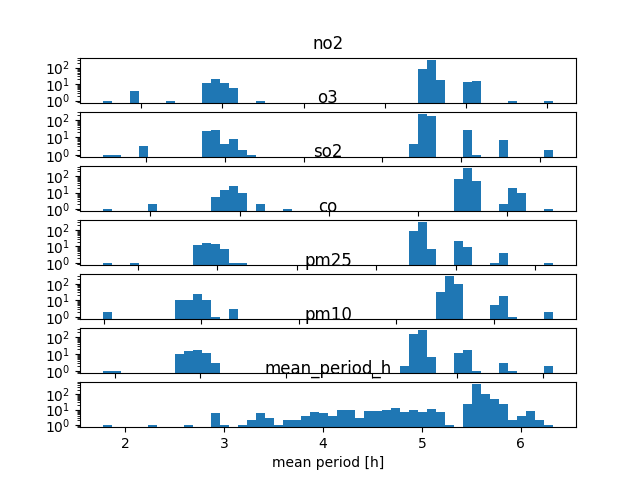

In [26]:
# visualize in histogram
cols = ["no2", "o3", "so2", "co", "pm25", "pm10", "mean_period_h"]
_, axes = plt.subplots(len(cols))
for col, ax in zip(cols, axes):
    ax.hist(df_pivot[col].to_numpy(), bins=50)
    ax.set_title(col)
    ax.set_yscale("log")


ax.set_xlabel("mean period [h]")

Conclusion: the bulk of the data has an average update period of 5-6 hours. Hence taking a 3 hour average will not be usefull. In practice this means that intra day variations will be hard to see (eg morning or evening traffic). The day to day evolution will be visible, so trends over larger periods can be shown.

Possible improvements:
- Interactive plotting
- Check of data frequency vs location. It might be that the update rate for more interesting locations is higher

## Analysis of the geo data

As shown above, there can be multiple locationsIds per location. The idea is to aggregate the data based on location. Based on the coordinate data we will try to get some insights if this is possible. Furthermore we will do a quelity check on the the coordinate data. For this we will use the geopy library (https://pypi.org/project/geopy/) connected to the Nominatim service (https://nominatim.org/).

A simple endpoint is implemented in the openaqtools.getools package. This package behaves as a coordinate store. To avoid requesting to much to the Nomatim service, it stores queried data locally.


In [15]:
from geopy.geocoders import Nominatim
from geopy import distance
from openaqtools.geo import coordinate_store

geolocator = Nominatim(user_agent="temp")
file_name = "../data/locations.parquet"
cs = coordinate_store(geolocator, file_name)

In [ ]:
# fill up coordinate store
for location in df_messages["location"].unique():
    cs.get(location)

In [16]:
print(len(cs.get_all()))
cs.get_all().head()

813


location,latitude,longitude
str,f64,f64
"""Leugnies""",50.2245,4.1961682
"""Ramillies""",50.206087,3.2610415
"""Hertain""",50.614111,3.2880161
"""Uikhoven""",50.925004,5.7254553
"""Voeren""",50.746555,5.839016


In [21]:
# join measurement table with reference locations
df_refloc = cs.get_all().rename({"latitude": "ref_latitude", "longitude": "ref_longitude"})
df_locations = df_messages.join(df_refloc, on="location")

# calculate per measurement: distance between measurement and reference location
df_locations = df_locations.with_columns(
    pl.struct(["latitude", "longitude", "ref_latitude", "ref_longitude"])
    .map_elements(lambda t: distance.distance(
        (t["latitude"],t["longitude"]),
        (t["ref_latitude"],t["ref_longitude"])).kilometers)
        .alias("distance[km]")
        )

# aggregate distances to mean and std
df_locations_agg = df_locations.group_by("location").agg([
    pl.col("distance[km]").mean().alias("mean distance"),
    pl.col("distance[km]").std().alias("std distance"),
    pl.col("ref_latitude").mean(),
    pl.col("ref_longitude").mean(),
    pl.col("latitude").mean(),
    pl.col("longitude").mean()
    ])

# show some data where mean distance is high
df_locations_agg.sort("mean distance", descending=True).head(10)


location,mean distance,std distance,ref_latitude,ref_longitude,latitude,longitude
str,f64,f64,f64,f64,f64,f64
"""Moen""",12881.004597,0.0,7.442526,151.858495,50.769973,3.397427
"""Arbre""",10495.912547,0.0,-14.693855,-75.114469,50.612404,3.816521
"""Cordes""",8686.373406,0.0,34.303363,-112.166827,50.688458,3.532936
"""Roy""",8197.854711,0.0,41.171536,-112.027374,50.18586,5.40707
"""Beaumont""",8051.344509,0.0,30.086046,-94.101846,50.219042,4.249786
"""On""",7672.552117,0.0,-18.470231,15.743442,50.17382,5.28783
"""Mont""",7497.459751,0.0,47.375267,-109.638757,50.35335,4.90291
"""Corporate Vill…",7400.565029,0.0,37.13757,-93.299721,50.889898,4.4580055
"""Mal""",7284.312467,0.0,26.786495,88.667818,50.768474,5.521464


In [20]:
# show some data where std distance is big
df_locations_agg.sort("std distance", descending=True).head(10)

location,mean distance,std distance,ref_latitude,ref_longitude,latitude,longitude
str,f64,f64,f64,f64,f64,f64
"""Nieuwerkerken""",21.25932,36.36576,50.865363,5.193901,50.879419,4.892688
"""Sint-Maria-Oud…",0.412971,0.605334,50.833845,3.794944,50.830762,3.793697
"""Ooike""",1.069575,0.059811,50.873362,3.566119,50.868717,3.564113
"""Breendonk""",0.184631,0.0,51.042477,4.324486,51.04309,4.32204
"""Wasseiges""",0.537491,0.0,50.621009,5.006907,50.61754,5.00162
"""Ans""",1.58562,0.0,50.667986,5.507754,50.660213,5.526552
"""Roesbrugge-Har…",0.437882,0.0,50.915053,2.626259,50.918879,2.624796
"""Houdremont""",0.066854,0.0,49.942041,4.944594,49.94148,4.94426
"""Cras-Avernas""",0.084473,0.0,50.697898,5.122837,50.69733,5.12363


Text(0.5, 0, 'mean period [h]')

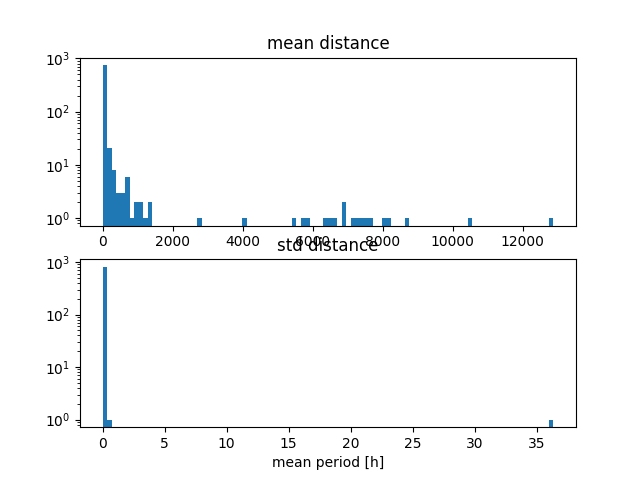

In [24]:
# visualize in histogram
cols = ["mean distance", "std distance"]
_, axes = plt.subplots(len(cols))
for col, ax in zip(cols, axes):
    ax.hist(df_locations_agg[col].to_numpy(), bins=100)
    ax.set_title(col)
    ax.set_yscale('log')

ax.set_xlabel("mean period [h]")

Conclusion:
- There are a few dozen measurements with coordinates that are significantly different from the reference location. Most likely this is due to different location identification in the Nomatim service so not issue in the data detected.
- The standard deviation on the coordinates is 0 except for 3 locations. This means that the coordinates have a high data quality



## Overall conclusion

In this notebook we did a first exploration of the data. Some findings:
- The queue has an ingestion of data every 6h of +- 3500 messages (not checked in this notebook but van be seen from AWS queue monitoring)
- We have data on 6 pollutants in Belgium, spread over 814 locations
- There are some attribites from which the meaning is not clear. Only the entity attribute is probably not related to the data
- A part of the data has an update rate of +-2h, while the bulk of the data has an update rate of +- 5,5h. Calculating a 3h avergage will hence not be possible for all the data
- The location information has a good quality. We can aggregate based on location